In [17]:
import os
import numpy as np
import pandas as pd

from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib
from IPython.display import display
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from yellowbrick.target import FeatureCorrelation
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

## Read the data

In [3]:
genre_data=pd.read_csv("data_by_genres.csv")

In [4]:
year_data=pd.read_csv("data_by_year.csv")

In [5]:
data=pd.read_csv("data.csv")

In [6]:
artist_data=pd.read_csv("data_by_artist.csv")

In [21]:
list_df=[genre_data, year_data, data, artist_data]

In [25]:
list_df=[genre_data, year_data, data, artist_data]
for df in list_df:
    display(df.head(2))
    print("------" * 17)

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834    0.3616 -31.514333     0.040567   75.336500   
1  0.450678          0.477762    0.1310 -16.854000     0.076817  120.285667   

    valence  popularity  key  
0  0.103783   27.833333    6  
1  0.221750   52.500000    5

------------------------------------------------------------------------------------------------------


mode  year  acousticness  danceability    duration_ms    energy  \
0     1  1921      0.886896      0.418597  260537.166667  0.231815   
1     1  1922      0.938592      0.482042  165469.746479  0.237815   

   instrumentalness  liveness   loudness  speechiness       tempo   valence  \
0          0.344878   0.20571 -17.048667     0.073662  101.531493  0.379327   
1          0.434195   0.24072 -19.275282     0.116655  100.884521  0.535549   

   popularity  key  
0    0.653333    2  
1    0.140845   10

------------------------------------------------------------------------------------------------------


valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz             0.878   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8             0.000   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   

   speechiness   tempo  
0       0.0366  80.954  
1       0.4150  60.936

------------------------------------------------------------------------------------------------------


mode  count  acousticness                           artists  danceability  \
0     1      9      0.590111  "Cats" 1981 Original London Cast      0.467222   
1     1     26      0.862538         "Cats" 1983 Broadway Cast      0.441731   

     duration_ms    energy  instrumentalness  liveness  loudness  speechiness  \
0  250318.555556  0.394003          0.011400  0.290833   -14.448     0.210389   
1  287280.000000  0.406808          0.081158  0.315215   -10.690     0.176212   

        tempo   valence  popularity  key  
0  117.518111  0.389500   38.333333    5  
1  103.044154  0.268865   30.576923    5

------------------------------------------------------------------------------------------------------


### General info about the data

In [27]:
for df in [genre_data, data]:
    display(df.info())
    print("---" * 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


None

---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity      

None

---------------------------------------------------


In [29]:
# Created a decade column
year_data['decade'] = year_data['year'].apply(lambda x : f"{int(x/10)* 10}s")
year_data

mode  year  acousticness  danceability    duration_ms    energy  \
0      1  1921      0.886896      0.418597  260537.166667  0.231815   
1      1  1922      0.938592      0.482042  165469.746479  0.237815   
2      1  1923      0.957247      0.577341  177942.362162  0.262406   
3      1  1924      0.940200      0.549894  191046.707627  0.344347   
4      1  1925      0.962607      0.573863  184986.924460  0.278594   
..   ...   ...           ...           ...            ...       ...   
95     1  2016      0.284171      0.600202  221396.510295  0.592855   
96     1  2017      0.286099      0.612217  211115.696787  0.590421   
97     1  2018      0.267633      0.663500  206001.007133  0.602435   
98     1  2019      0.278299      0.644814  201024.788096  0.593224   
99     1  2020      0.219931      0.692904  193728.397537  0.631232   

    instrumentalness  liveness   loudness  speechiness       tempo   valence  \
0           0.344878  0.205710 -17.048667     0.073662  101.531493  0.379327   
1           0.434195  0.240720 -19.275282     0.116655  100.884521  0.535549   
2           0.371733  0.227462 -14.129211     0.093949  114.010730  0.625492   
3           0.581701  0.235219 -14.231343     0.092089  120.689572  0.663725   
4           0.418297  0.237668 -14.146414     0.111918  115.521921  0.621929   
..               ...       ...        ...          ...         ...       ...   
95          0.093984  0.181170  -8.061056     0.104313  118.652630  0.431532   
96          0.097091  0.191713  -8.312630     0.110536  117.202740  0.416476   
97          0.054217  0.176326  -7.168785     0.127176  121.922308  0.447921   
98          0.077640  0.172616  -7.722192     0.121043  120.235644  0.458818   
99          0.016376  0.178535  -6.595067     0.141384  124.283129  0.501048   

    popularity  key decade  
0     0.653333    2  1920s  
1     0.140845   10  1920s  
2     5.389189    0  1920s  
3     0.661017   10  1920s  
4     2.604317    5  1920s  
..         ...  ...    ...  
95   59.647190    0  2010s  
96   63.263554    1  2010s  
97   63.296243    1  2010s  
98   65.256542    1  2010s  
99   64.301970    1  2020s  

[100 rows x 15 columns]

## EDA process

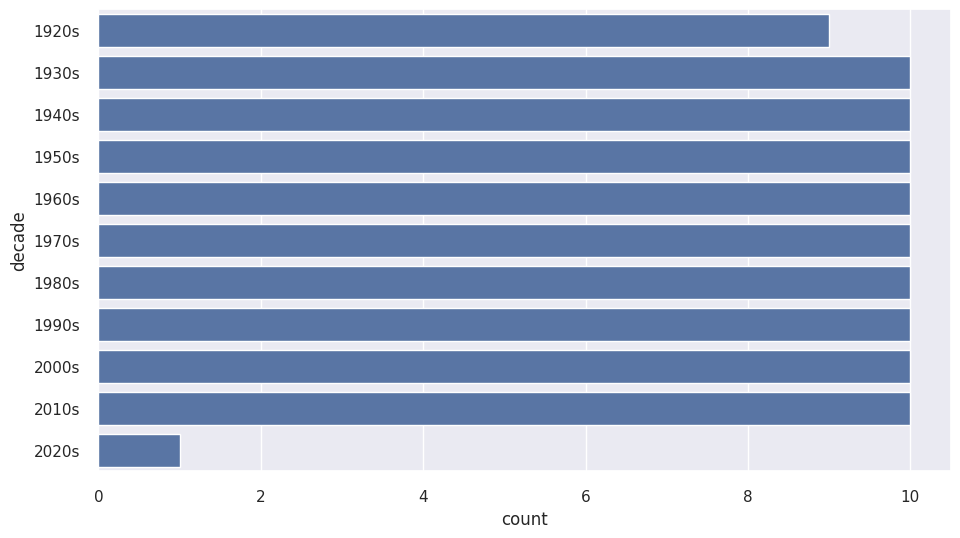

In [59]:
sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(year_data['decade'])
plt.show()

In [60]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(year_data, x='decade', y=sound_features, title='Trend of various sound features over decades')
fig.show()

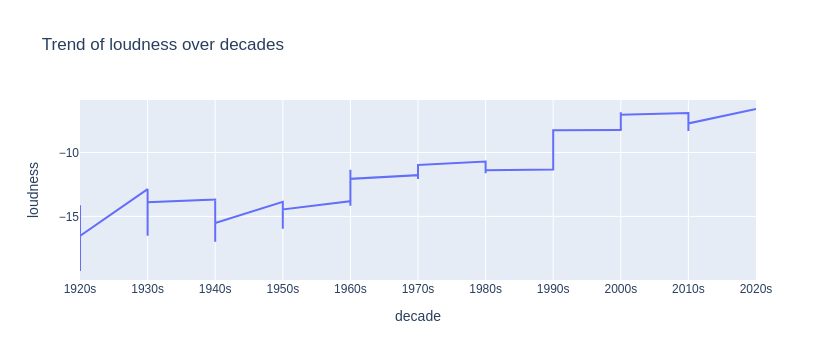

In [63]:
px.line(year_data, x='decade', y='loudness', title='Trend of loudness over decades')

In [66]:
top10_genres=genre_data.sort_values(by="popularity", ascending=False).head(10)

px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group', title='Trend of various sound features over top 10 genres')

### Word cloud

In [69]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Word cloud for the genres

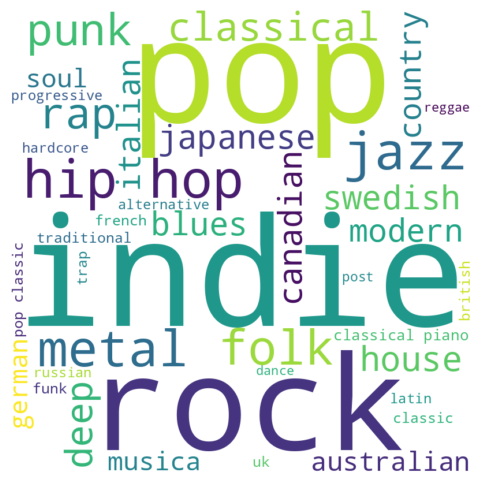

In [70]:
comment_words= " ".join(genre_data['genres'].astype(str))
wordcloud=WordCloud(width=800, height=800, background_color='white', max_words=40, min_font_size=10).generate(comment_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word cloud for artist

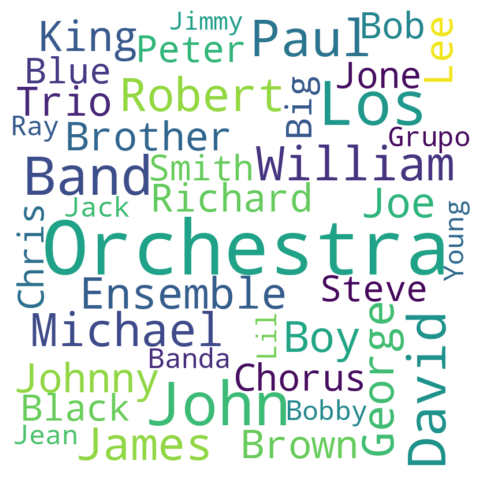

In [71]:
comment_words= " ".join(artist_data['artists'].astype(str))
wordcloud=WordCloud(width=800, height=800, background_color='white', min_word_length=3, max_words=40, min_font_size=10).generate(comment_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [72]:
artist_data[['popularity','artists']].sort_values('popularity', ascending=False).head(10)

popularity          artists
20966        93.0      Ritt Momney
14354        92.0        Lele Pons
15070        90.0  Los Legendarios
11764        89.0         Jerry Di
28263        88.0      salem ilese
23687        88.0        Surf Mesa
7463         88.0           Emilee
213          87.0              A7S
26318        86.0             Towy
16453        86.0        Master KG

## Correlation between popuarity and the main audio features

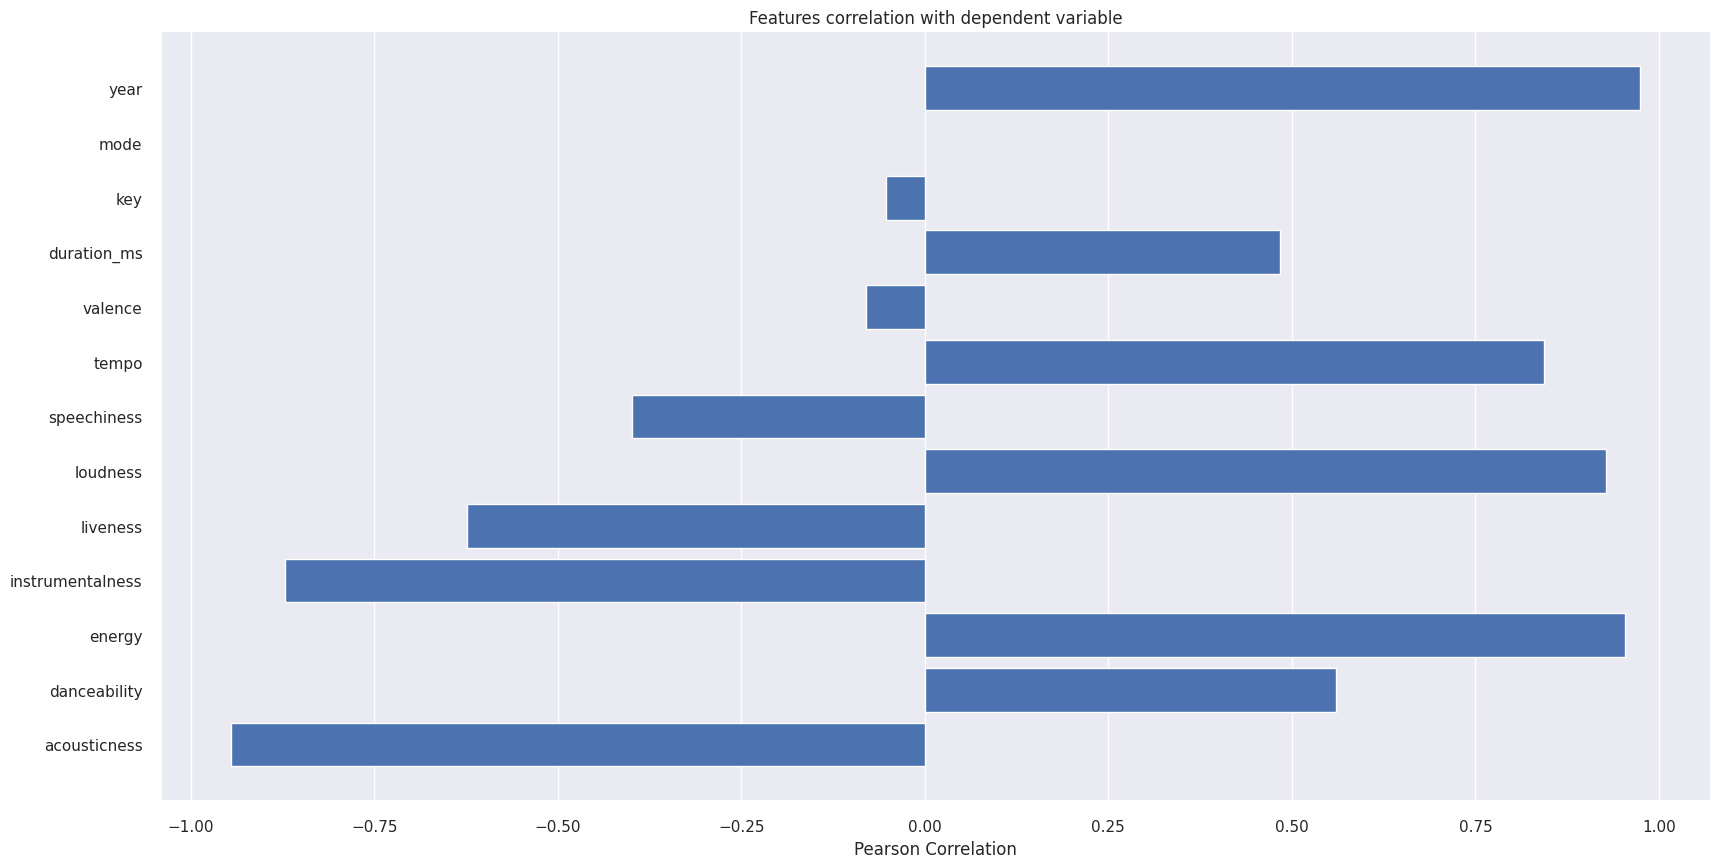

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [73]:
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','key','mode','year']

X, y = year_data[feature_names], year_data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,10)

# Fit the data to the visualizer
visualizer.fit(X, y)     
visualizer.show()

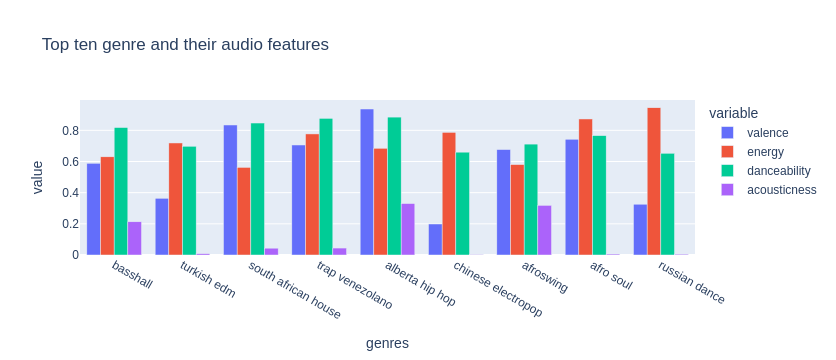

In [77]:
top_genres = genre_data.sort_values(by="popularity", ascending=False).iloc[0:9]

fig = px.bar(top_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group',title="Top ten genre and their audio features")
fig.show()

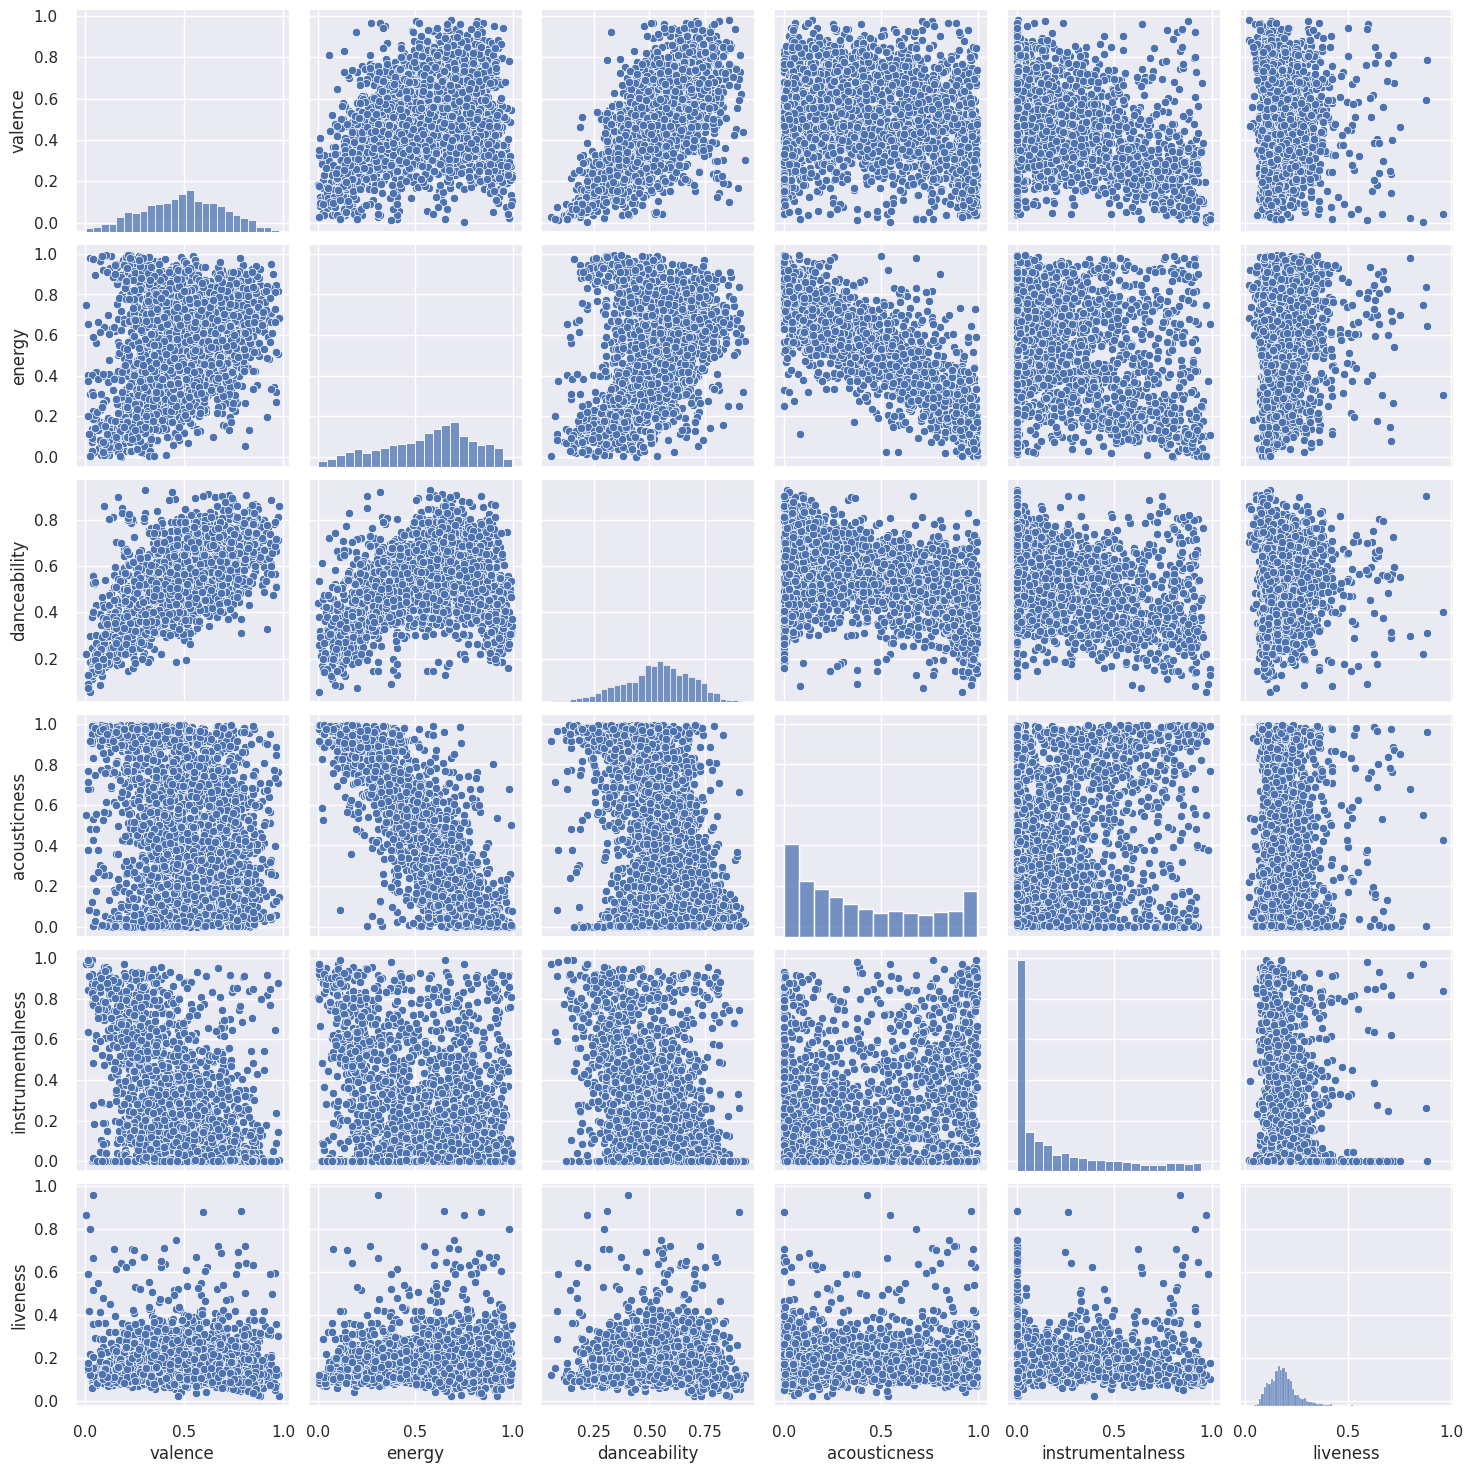

In [75]:
sns.pairplot(genre_data[['valence', 'energy', 'danceability', 'acousticness','instrumentalness', 'liveness']])
plt.show()